# Plot surface elevations, bed topography, and annual speed peaks along the centerline

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import xarray as xr
import rioxarray as rxr
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from tqdm.auto import tqdm

## Define paths in directory

In [16]:
# Path to Hubbard data for convenience
data_path = os.getcwd()

# Where figure will be saved
#figures_out_path = os.path.join(data_path, 'figures') 
figures_out_path = data_path
# Bed topography
bed_fn = os.path.join(data_path, '../data/bed_topo', 'Hubbard_IfSAR_Bathy_Millan_Icebridge.tiff')
# Centerline
cl_fn = os.path.join(data_path, '../data/velocity', 'center_50m.gpkg')
# Surface elevations
h_cl_fn = os.path.join(data_path, '../data/DEMs', 'centerline_surface_elevation_timeseries_smooth.csv')

## Load data

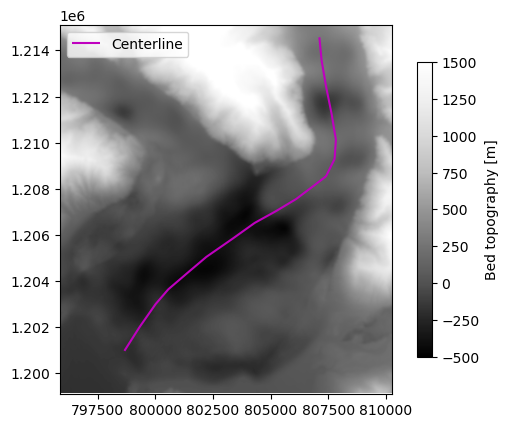

In [10]:
# Centerline
cl = gpd.read_file(cl_fn)
# calculate distance vector
def create_distance_vector(line):
    x, y = line.coords.xy[0], line.coords.xy[1]
    line_dist = np.zeros(len(line.coords.xy[0]))
    for i in range(1, len(line.coords.xy[0])):
        line_dist[i] = np.sqrt((x[i]-x[i-1])**2 + (y[i]-y[i-1])**2) + line_dist[i-1]
    return line_dist
cl_dist = create_distance_vector(cl.geometry[0])
# Flip to start near terminus
cl_dist = np.flip(cl_dist)

# Bed
bed = xr.open_dataset(bed_fn)
x_samp, y_samp = cl.geometry[0].coords.xy
bed_cl = [bed.sel(x=x, y=y, method='nearest').band_data.data[0] for x, y in list(zip(x_samp, y_samp))]

# Surface elevations along centerline
h_cl_df = pd.read_csv(h_cl_fn)
h_cl_df['Date'] = pd.to_datetime(h_cl_df['Date'])

# Plot bed and centerline map
fig, ax = plt.subplots()
bed_im = ax.imshow(bed.band_data.data[0], cmap='Greys_r', clim=(-0.5e3, 1.5e3),
                   extent=(np.min(bed.x.data), np.max(bed.x.data),
                           np.min(bed.y.data), np.max(bed.y.data)))
cl.plot(ax=ax, color='m', label='Centerline')
ax.legend(loc='upper left')
fig.colorbar(bed_im, shrink=0.8, label='Bed topography [m]')

plt.show()

## Calculate speed peak strengths along centerline

Copied from Amy's `double_peak_strength` notebook

In [12]:
# -----Calculate summer and winter speed speaks
# Load velocity
ds_fn = os.path.join(data_path, '../data/velocity', 'Hubbard_S1.nc')
ds = xr.load_dataset(ds_fn)
ds["v"] = np.sqrt(ds.vx**2 + ds.vy**2).fillna(0)
ds["month"] = ds.time.dt.month
ds["year"] = ds.time.dt.year
ds["doy"] = ds.time.dt.dayofyear
ds = ds.rio.write_crs('EPSG:3413')
ds = ds.rio.reproject('EPSG:3338')
ds = xr.where(ds > 1e10, np.nan, ds)
ds = xr.where(ds==0, np.nan, ds)


  0%|          | 0/6 [00:00<?, ?it/s]

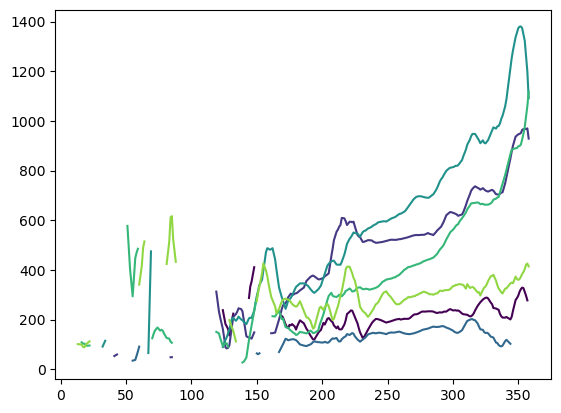

In [13]:
# Calculate strength of speed peaks
strengths_cl = pd.DataFrame()
strengths_norm_cl = pd.DataFrame()
years = [2016, 2017, 2018, 2019, 2020, 2021]
fig, ax = plt.subplots()
i = 0
for year in tqdm(years):

    # Winter peak
    winter_mask = np.logical_or(
        np.logical_and(ds.month >= 11, ds.year == year),
        np.logical_and(ds.month <= 2, ds.year == year+1)
    )
    winter_velocities = ds.v[winter_mask, :, :]
    winter_peak = winter_velocities.max(dim='time')

    # Middle peak
    middle_mask = np.logical_and(
        np.logical_and(ds.month >= 2.05, ds.month <= 4),
        ds.year == year+1,
    )
    middle_velocities = ds.v[middle_mask, :, :]
    middle_min = middle_velocities.min(dim='time')

    # Summer peak
    summer_mask = np.logical_and(
        np.logical_and(ds.month >= 4, ds.month <= 6),
        ds.year == year+1,
    )
    summer_velocities = ds.v[summer_mask, :, :]
    summer_peak = summer_velocities.max(dim='time')

    # Strength of double peaks 
    avg_mag = (winter_peak + summer_peak)/2
    mask = (winter_peak < middle_min) | (summer_peak < 500)
    strength = (winter_peak - middle_min) 
    strength = xr.where(mask, np.nan, strength)

    # Sample along centerline
    strength_cl_np = [float(strength.sel(x=x, y=y, method='nearest').data) for (x, y) in list(zip(x_samp, y_samp))]
    strength_cl = pd.DataFrame({year: strength_cl_np})

    # Smooth over a 500 m window
    strength_cl_smooth = strength_cl.rolling(10).mean()
    strengths_cl = pd.concat([strengths_cl, strength_cl_smooth], axis=1)
    ax.plot(strengths_cl[year], '-', color=plt.cm.viridis(i/len(years)))
    i+=1
    
plt.show() 

## Plot surface elevation + bed + mean speed peaks

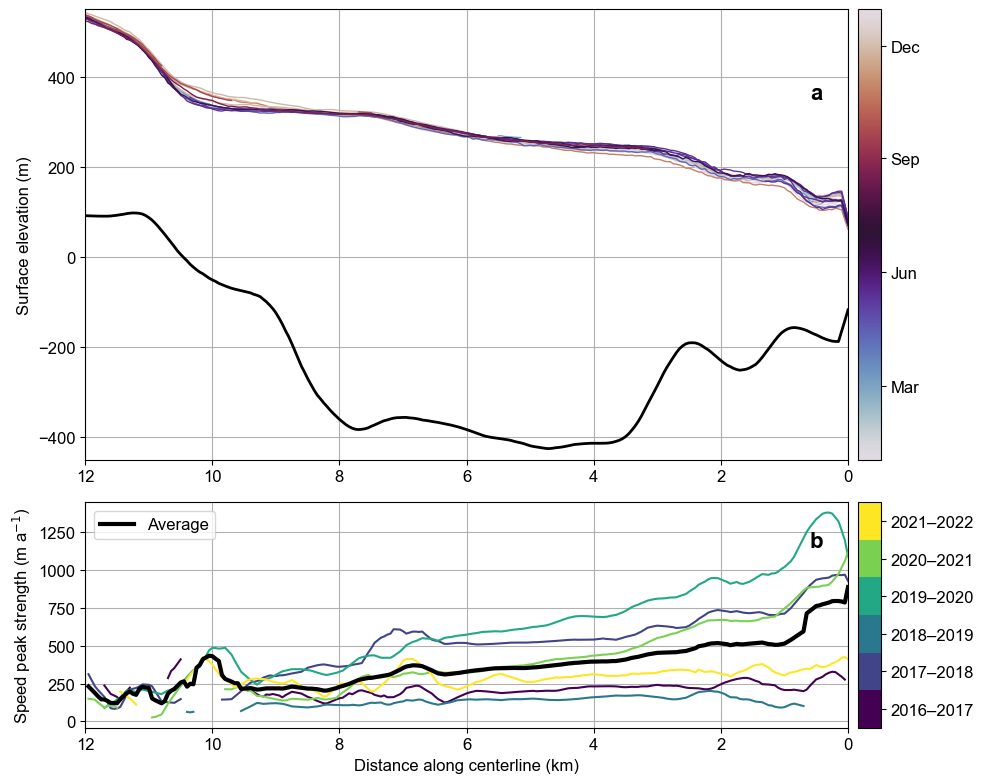

FileNotFoundError: [Errno 2] No such file or directory: '/data/hubbard/Hubbard2024/make_paper_figures/figures/centerline_surface_elevations_smooth_speed_strength.png'

In [14]:
# Set up figure
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(2, 1, figsize=(10,8), gridspec_kw={'height_ratios':[2, 1]})
lw=1
xlim = [12,0] # km from terminus

# Moving average for bed
def moving_average(x, w=8):
    return np.convolve(x, np.ones(w), 'same') / w
bed_cl_smooth = moving_average(bed_cl)


# Identify where the peak subsides in weaker speed years
# weak_dist = 10.7e3

### a) Surface + bed elevations
# Reorder to put more drastic changes on top
h_cl_df['Month'] = pd.Categorical(h_cl_df['Date'].dt.month, [1, 2, 3, 10, 11, 12, 
                                                             4, 5, 6, 7, 8, 9])
h_cl_df = h_cl_df.sort_values(by='Month')
# Define colormap for surface profiles
cmap = plt.cm.twilight
# Surfaces
h_cols = [x for x in list(h_cl_df.columns) if '.' in x]
for i in range(len(h_cl_df)):
    month = pd.DatetimeIndex(h_cl_df['Date']).month[i]
    color = cmap((month-1)/11)
    ax[0].plot(np.divide(cl_dist, 1e3), h_cl_df.iloc[i][h_cols], '-', linewidth=lw, color=color)
# Bed
ax[0].plot(np.divide(cl_dist, 1e3), bed_cl_smooth, '-k', linewidth=lw+1, label='Bed topography')
# Plot the colorbar
sm = ScalarMappable(cmap=cmap)
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="3%", pad=0.1)
cbar = fig.colorbar(sm, cax=cax1, orientation='vertical')
months = [3, 6, 9, 12]
labels = list(pd.to_datetime(months, format='%m').month_name().str.slice(stop=3))
ticks = [pd.DatetimeIndex([f'2017-0{month}-01']).dayofyear[0] / 365 if month < 10 
         else pd.DatetimeIndex([f'2017-{month}-01']).dayofyear[0] / 365 
         for month in months]
cbar.ax.set_yticks(ticks)
cbar.ax.set_yticklabels(labels)
ax[0].grid()
ax[0].set_ylabel('Surface elevation (m)')
ax[0].set_xlim(xlim)
ax[0].set_ylim(-450, 550)

### b) Speed strengths
cmap = plt.cm.viridis
colors=[]
for i, year in enumerate(years):
    colors.append(cmap(i/(len(years)-1)))
    ax[1].plot(np.divide(cl_dist, 1e3), strengths_cl[year], '-', color=colors[i])
ax[1].plot(np.divide(cl_dist, 1e3), strengths_cl.mean(axis=1), '-k', linewidth=lw+2, label='Average')
ax[1].legend(loc='upper left')
ax[1].set_xlim(xlim)
ax[1].set_xlabel('Distance along centerline (km)')
ax[1].set_ylabel('Speed peak strength (m a$^{-1}$)')
# Plot colorbar
listed_cmap = matplotlib.colors.ListedColormap(colors)
bounds = np.arange(len(colors) + 1)  
norm = matplotlib.colors.BoundaryNorm(bounds, listed_cmap.N)
sm = matplotlib.cm.ScalarMappable(cmap=listed_cmap, norm=norm)
divider3 = make_axes_locatable(ax[1])
cax3 = divider3.append_axes("right", size="3%", pad=0.1)
cbar = fig.colorbar(sm, cax=cax3, ticks=np.arange(len(colors)) + 0.5, orientation='vertical')
cbar.ax.set_yticklabels([f'{year}–{year+1}' for year in years])  # Customize labels
cbar.ax.tick_params(which='minor', length=0)  

### Add panel labels, adjust axes
labels = ['a', 'b', 'c']
for i, axis in enumerate(ax):
    axis.text((axis.get_xlim()[1] - axis.get_xlim()[0]) * 0.95 + axis.get_xlim()[0], 
              (axis.get_ylim()[1] - axis.get_ylim()[0]) * 0.8 + axis.get_ylim()[0], 
              labels[i], fontweight='bold', fontsize=fontsize+4)
    axis.grid(True)
    # axis.axvline(weak_dist, color='k', linestyle='--', linewidth=1)

fig.tight_layout()
plt.show()

# Save figure
fig_fn = os.path.join(figures_out_path, 'centerline_surface_elevations_smooth_speed_strength.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

In [7]:
# # -----Normalize speeds by average at each centerline point


# # Set up figure
# fontsize=12
# plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
# fig, ax = plt.subplots(2, 1, figsize=(10,10), gridspec_kw={'height_ratios':[2, 1]})
# lw=1
# xlim = [12e3,0]

# # Moving average for bed
# def moving_average(x, w=8):
#     return np.convolve(x, np.ones(w), 'same') / w
# bed_cl_smooth = moving_average(bed_cl)


# # Identify where the peak subsides in weaker speed years
# weak_dist = 10.7e3

# ### a) Surface elevations  + bed elevations
# # Reorder to put more drastic changes on top
# h_cl_df['Month'] = pd.Categorical(h_cl_df['Date'].dt.month, [1, 2, 3, 10, 11, 12, 
#                                                              4, 5, 6, 7, 8, 9])
# h_cl_df = h_cl_df.sort_values(by='Month')
# # Define colormap for surface profiles
# cmap = plt.cm.twilight
# # Plot surfaces
# h_cols = [x for x in list(h_cl_df.columns) if '.' in x]
# for i in range(len(h_cl_df)):
#     month = pd.DatetimeIndex(h_cl_df['Date']).month[i]
#     color = cmap((month-1)/11)
#     ax[0].plot(cl_dist, h_cl_df.iloc[i][h_cols], '-', linewidth=lw, color=color)
# # Plot bed
# ax[0].plot(cl_dist, bed_cl_smooth, '-k', linewidth=lw+1, label='Bed topography')
# # Plot the colorbar
# sm = ScalarMappable(cmap=cmap)
# divider1 = make_axes_locatable(ax[0])
# cax1 = divider1.append_axes("right", size="3%", pad=0.1)
# cbar = fig.colorbar(sm, cax=cax1, orientation='vertical')
# months = [3, 6, 9, 12]
# labels = list(pd.to_datetime(months, format='%m').month_name().str.slice(stop=3))
# ticks = [pd.DatetimeIndex([f'2017-0{month}-01']).dayofyear[0] / 365 if month < 10 
#          else pd.DatetimeIndex([f'2017-{month}-01']).dayofyear[0] / 365 
#          for month in months]
# cbar.ax.set_yticks(ticks)
# cbar.ax.set_yticklabels(labels)
# ax[0].grid()
# ax[0].set_ylabel('Surface elevation (m)')
# ax[0].set_xlim(xlim)
# ax[0].set_ylim(-450, 550)
# # # Bed elevations
# # ax[1].set_ylabel('Bed elevation (m)')
# # ax[1].set_xlim(xlim)
# # ax[1].set_ylim(-500, 100)
# # ax[1].grid()
# # divider2 = make_axes_locatable(ax[1])
# # cax2 = divider2.append_axes("right", size="3%", pad=0.1)
# # cax2.set_visible(False)

# ### b) Speed strengths
# cmap = plt.cm.viridis
# colors=[]
# for i, year in enumerate(years):
#     colors.append(cmap(i/(len(years)-1)))
#     ax[1].plot(cl_dist, strengths_cl[year], '-', color=colors[i])
# ax[1].plot(cl_dist, strengths_cl.mean(axis=1), '-k', linewidth=lw+2, label='Average')
# ax[1].legend(loc='upper left')
# ax[1].set_xlim(xlim)
# ax[1].set_xlabel('Distance along centerline (m)')
# ax[1].set_ylabel('Speed peak strength (m a$^{-1}$)')
# # Plot colorbar
# listed_cmap = matplotlib.colors.ListedColormap(colors)
# bounds = np.arange(len(colors) + 1)  
# norm = matplotlib.colors.BoundaryNorm(bounds, listed_cmap.N)
# sm = matplotlib.cm.ScalarMappable(cmap=listed_cmap, norm=norm)
# divider3 = make_axes_locatable(ax[1])
# cax3 = divider3.append_axes("right", size="3%", pad=0.1)
# cbar = fig.colorbar(sm, cax=cax3, ticks=np.arange(len(colors)) + 0.5, orientation='vertical')
# cbar.ax.set_yticklabels([f'{year}–{year+1}' for year in years])  # Customize labels
# cbar.ax.tick_params(which='minor', length=0)  

# ### Add panel labels, adjust axes
# labels = ['a', 'b', 'c']
# for i, axis in enumerate(ax):
#     axis.text((axis.get_xlim()[1] - axis.get_xlim()[0]) * 0.95 + axis.get_xlim()[0], 
#               (axis.get_ylim()[1] - axis.get_ylim()[0]) * 0.8 + axis.get_ylim()[0], 
#               labels[i], fontweight='bold', fontsize=fontsize+4)
#     axis.grid(True)
#     # axis.axvline(weak_dist, color='k', linestyle='--', linewidth=1)

# plt.show()

# # Save figure
# fig_fn = os.path.join(figures_out_path, 'centerline_surface_elevations_smooth_speed_strength.png')
# fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
# print('Figure saved to file:', fig_fn)

In [17]:
h_cl_df

,Date,Dataset,0.0,50.0,100.0,150.0,200.0,250.0,300.0,350.0,...,17500.0,17550.0,17600.0,17650.0,17700.0,17750.0,17800.0,17850.0,17900.0,Month
63,2021-01-27,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
33,2017-01-17,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,114.651088,115.587621,117.744466,118.162268,118.443939,122.683601,122.865578,99.190118,75.025813,1
34,2017-01-29,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
36,2018-01-17,ArcticDEM,458.334216,610.135071,761.444080,759.242029,757.161047,755.106885,753.252954,751.363745,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
51,2020-01-13,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,2019-09-28,OIB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
91,2022-09-11,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
28,2016-09-17,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
49,2019-09-05,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9


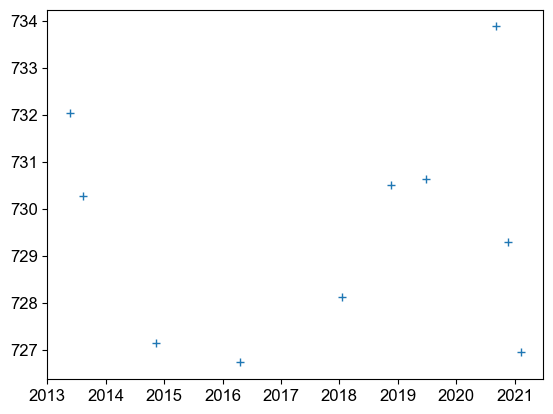

In [25]:
plt.plot(h_cl_df['Date'], h_cl_df['1000.0'], '+')